In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.cm as cm
from contextlib import nullcontext

# This imports from /root/sam_vggt/sam-hq/segment_anything/
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

/root/miniconda3/envs/vggt/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/root/miniconda3/envs/vggt/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/root/sam_vggt/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/root/sam_vggt/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwritin

In [2]:
import torch.nn as nn
from typing import Type
from segment_anything import PromptEncoder, MaskDecoder, TwoWayTransformer

In [3]:
import os, math, sys
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.cm as cm
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images_square

def get_patch_size(model) -> int:
    cand_attrs = [
        "backbone.patch_size",
        "backbone.vit.patch_size",
        "backbone.vit.patch_embed.patch_size",
        "backbone.patch_embed.patch_size",
    ]
    for ca in cand_attrs:
        try:
            obj = model
            for part in ca.split("."):
                obj = getattr(obj, part)
            if isinstance(obj, (tuple, list)):
                return int(obj[0])
            return int(obj)
        except Exception:
            pass
    return 14

In [4]:
import matplotlib.pyplot as plt
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
img_dir = "data/kitchen/images"
img_list = ["00.png", "01.png", "02.png", "03.png"]

## SAM embedding output

set up pretrained model

In [6]:

autocast_ctx = torch.autocast(device_type="cuda", dtype=torch.float16) if device == "cuda" else nullcontext()

model_type = "vit_l"

# Using SAM-HQ checkpoint with regular MaskDecoder (updated in build_sam.py)
sam = sam_model_registry[model_type](checkpoint="sam-hq/checkpoints/sam_hq_vit_l.pth").to(device)
sam.eval()

building sam


_IncompatibleKeys(missing_keys=[], unexpected_keys=['mask_decoder.hf_token.weight', 'mask_decoder.hf_mlp.layers.0.weight', 'mask_decoder.hf_mlp.layers.0.bias', 'mask_decoder.hf_mlp.layers.1.weight', 'mask_decoder.hf_mlp.layers.1.bias', 'mask_decoder.hf_mlp.layers.2.weight', 'mask_decoder.hf_mlp.layers.2.bias', 'mask_decoder.compress_vit_feat.0.weight', 'mask_decoder.compress_vit_feat.0.bias', 'mask_decoder.compress_vit_feat.1.weight', 'mask_decoder.compress_vit_feat.1.bias', 'mask_decoder.compress_vit_feat.3.weight', 'mask_decoder.compress_vit_feat.3.bias', 'mask_decoder.embedding_encoder.0.weight', 'mask_decoder.embedding_encoder.0.bias', 'mask_decoder.embedding_encoder.1.weight', 'mask_decoder.embedding_encoder.1.bias', 'mask_decoder.embedding_encoder.3.weight', 'mask_decoder.embedding_encoder.3.bias', 'mask_decoder.embedding_maskfeature.0.weight', 'mask_decoder.embedding_maskfeature.0.bias', 'mask_decoder.embedding_maskfeature.1.weight', 'mask_decoder.embedding_maskfeature.1.bias', 

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

preprocess images

In [7]:
transform = ResizeLongestSide(sam.image_encoder.img_size)  # 1024

x_1024_list = []
denorm_needed = []   # keep track for saving images
for name in img_list:
    img = Image.open(os.path.join(img_dir, name)).convert("RGB")
    im = np.array(img)                                      # [H,W,3] uint8

    im_resized = transform.apply_image(im)                  # [H',W',3] uint8

    # 0..255 float tensor, then SAM preprocess (pads + normalizes)
    x = torch.as_tensor(im_resized, dtype=torch.float32).permute(2,0,1)[None].to(device)  # [1,3,H',W']
    x_1024 = sam.preprocess(x)                                                 # [1,3,1024,1024]
    x_1024_list.append(x_1024)
    denorm_needed.append(name)

# stack to batch
x_1024_batch = torch.cat(x_1024_list, dim=0)  # [B,3,1024,1024]
print(f"x_1024_batch.shape: {x_1024_batch.shape}")

x_1024_batch.shape: torch.Size([4, 3, 1024, 1024])


Inference, get SAM embedding (B\*C\*H\*W)

In [8]:
with torch.no_grad(), autocast_ctx:
    feats, interms = sam.image_encoder(x_1024_batch)   # feats: [B,256,64,64]; interms: list of [B,H,W,C]
print(feats.shape)

torch.Size([4, 256, 64, 64])


In [9]:
print(interms[0].shape)

torch.Size([4, 64, 64, 1024])


## VGGT embedding output

load pretrained model

In [10]:
ckpt_path = "vggt/checkpoints/model.pt"

def load_local_vggt(ckpt: str, device="cuda"):
    model = VGGT()
    raw = torch.load(ckpt, map_location="cpu")
    if isinstance(raw, dict) and "state_dict" in raw:
        sd = raw["state_dict"]
    elif isinstance(raw, dict) and "model" in raw:
        sd = raw["model"]
    else:
        sd = raw
    sd = {k.replace("module.", ""): v for k, v in sd.items()}
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print(f"[VGGT] loaded. missing={len(missing)}, unexpected={len(unexpected)}")
    if missing:   print("  (first few missing):", missing[:8])
    if unexpected: print("  (first few unexpected):", unexpected[:8])
    return model.to(device).eval()

model = load_local_vggt(ckpt_path, device=device)

[VGGT] loaded. missing=0, unexpected=0


In [11]:
model.eval()

VGGT(
  (aggregator): Aggregator(
    (patch_embed): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=

preprocess images

In [12]:
imgs = load_and_preprocess_images_square([os.path.join(img_dir, name) for name in img_list], 896)[0].to(device)   # [N,3,H,W]
N, _, H, W = imgs.shape
print(f"imgs.shape: {imgs.shape}")
imgs_batched = imgs.unsqueeze(0)                             # [B=1,N,3,H,W]
patch = get_patch_size(model) or 14
gh, gw = H // patch, W // patch
assert gh > 0 and gw > 0, f"Bad grid: H,W={H,W}, patch={patch}"

imgs.shape: torch.Size([4, 3, 896, 896])


Alternative attention layer forwarding

In [13]:
with torch.no_grad():
    agg_tokens_list, ps_idx = model.aggregator(imgs_batched)


Extract the image embeddings

In [14]:

# tokens is concat of FA||GA at the last AA depth
tokens = agg_tokens_list[-1]                       # [B, N, Tpf, 2C]
B, Nf, Tpf, C2x = tokens.shape
print(f"tokens.shape: {tokens.shape}")
print(f"B: {B}")
print(f"Nf: {Nf}")
print(f"Tpf: {Tpf}")
print(f"C2x: {C2x}")
assert Nf == N
C = C2x // 2                                       # base channel dim

# Use the patch_start_idx returned by aggregator
# patches are from [patch_start_idx : patch_start_idx + P]
P = gh * gw
patch_start = ps_idx                                # int, typically 1 + num_register_tokens (1+4=5)
patch_tok = tokens[:, :, patch_start:patch_start+P, :]   # [B, N, P, 2C]

patch_tok = patch_tok.permute(0,1,3,2).contiguous().reshape(B, N, C2x, gh, gw)
print(f"patch_tok.shape: {patch_tok[0].shape}")

tokens.shape: torch.Size([1, 4, 4101, 2048])
B: 1
Nf: 4
Tpf: 4101
C2x: 2048
patch_tok.shape: torch.Size([4, 2048, 64, 64])


## Merge embedding from SAM and VGGT through MLP

In [14]:
sam_feats = feats
vggt_feats = patch_tok
assert sam_feats.shape[:1] == (len(img_list),)
assert vggt_feats.shape[:2] == (1, len(img_list))

# 1) Align shapes: collapse VGGT's batch dim (B=1) so frames become the batch
vggt_feats_bchw = vggt_feats.squeeze(0)                 # [4, 2048, 64, 64]

# 2) Concatenate channel-wise
x = torch.cat([sam_feats, vggt_feats_bchw], dim=1)      # [4, 2304, 64, 64]
print(f"x.shape: {x.shape}")

class PerPixelMLP(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, act: Type[nn.Module] = nn.GELU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_hidden, kernel_size=1, bias=True),
            act(),
            nn.Conv2d(c_hidden, c_out, kernel_size=1, bias=True),
        )
    def forward(self, x):
        return self.net(x)


head = PerPixelMLP(c_in=x.shape[1], c_hidden=768, c_out=256).to(device)
# 4) Forward through head -> matches SAM shape
sam_vggt_embed = head(x)                                     # [4, 256, 64, 64]
print(sam_vggt_embed.shape)

x.shape: torch.Size([4, 2304, 64, 64])
torch.Size([4, 256, 64, 64])


## Point Prompt encoding

In [15]:
point_coords = np.array([
    [[400, 200]]
    ]) 
point_labels = np.array([[1]])
# input_boxes = np.array([[250, 50, 700, 370]])

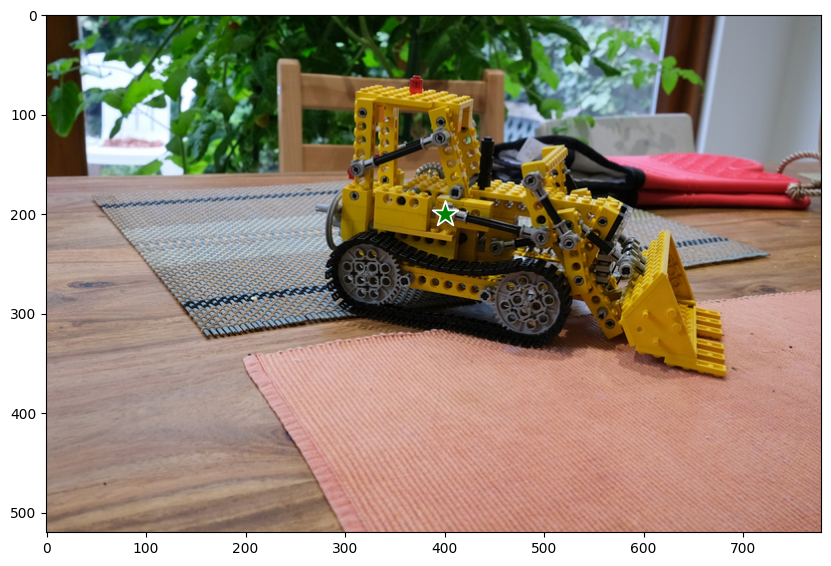

In [16]:
images = [Image.open(os.path.join(img_dir, name)).convert("RGB") for name in img_list]
image = images[0]
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(point_coords, point_labels, plt.gca())
# for box in input_boxes:
#     show_box(box, plt.gca())
plt.axis('on')
plt.show()  

In [17]:
# use the sam prompt encoder to encode the point prompt
sparse_embeddings, dense_embeddings = sam.prompt_encoder(
    points=(torch.from_numpy(point_coords).to(device), torch.from_numpy(point_labels).to(device)),
    boxes=None,
    masks=None)
print(f"sparse_embeddings.shape: {sparse_embeddings.shape}")
# BxNx(embed_dim), where N is determined by the number of input points and boxes.
print(f"dense_embeddings.shape: {dense_embeddings.shape}")


sparse_embeddings.shape: torch.Size([1, 2, 256])
dense_embeddings.shape: torch.Size([1, 256, 64, 64])


Extract the camera embedding

In [18]:
camera_tokens = tokens[:, :, 0]
print(f"camera_tokens.shape: {camera_tokens.shape}")


camera_tokens.shape: torch.Size([1, 4, 2048])


In [15]:
pose_enc_list = model.camera_head(agg_tokens_list)
cam_pose_enc = pose_enc_list[-1]
print("cam_pose_enc shape: ", cam_pose_enc.shape)

cam_pose_enc shape:  torch.Size([1, 4, 9])


In [21]:
print(Image.open(os.path.join(img_dir, img_list[0])).size)

(779, 520)


In [30]:
# concatentate the sam_vggt_embed from [4, 256, 64, 64] to [1, 256, 64, 64*number_of_images]
sam_vggt_embed_concat = sam_vggt_embed.reshape(1, 256, 64, 64*len(img_list))
print(sam_vggt_embed_concat.shape)

torch.Size([1, 256, 64, 256])


In [26]:
prompt_encoder = PromptEncoder(
    embed_dim=256,
    image_embedding_size=(64, 64*4),
    input_image_size=(1024, 1024*4),
    mask_in_chans=16,
).to(device)
# mask_decoder=MaskDecoder(
#     num_multimask_outputs=3,
#     transformer=TwoWayTransformer(
#         depth=2,
#         embedding_dim=256,
#         mlp_dim=2048,
#         num_heads=8,
#     ),
#     transformer_dim=256,
#     iou_head_depth=3,
#     iou_head_hidden_dim=256,
# )

In [27]:
# use the sam prompt encoder to encode the point prompt
sparse_embeddings, dense_embeddings = prompt_encoder(
    points=(torch.from_numpy(point_coords).to(device), torch.from_numpy(point_labels).to(device)),
    boxes=None,
    masks=None)
print(f"sparse_embeddings.shape: {sparse_embeddings.shape}")
# BxNx(embed_dim), where N is determined by the number of input points and boxes.
print(f"dense_embeddings.shape: {dense_embeddings.shape}")


sparse_embeddings.shape: torch.Size([1, 2, 256])
dense_embeddings.shape: torch.Size([1, 256, 64, 256])


In [28]:
sam_sparse = sparse_embeddings
vggt_cam = camera_tokens
k = 0  # index of the image that actually has the prompts

B, Np, _ = sam_sparse.shape
_, S, C_vggt = vggt_cam.shape

# pick the camera token of frame k and broadcast it to all Np prompts
cam_k = vggt_cam[:, k:k+1, :]                  # [1, 1, 2048]
cam_per_prompt = cam_k.expand(B, Np, C_vggt)   # [1, Np, 2048]

# concat on feature dim -> [1, Np, 2304]
fused_in = torch.cat([sam_sparse, cam_per_prompt], dim=-1)

class MLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        out_dim: int,
        act: Type[nn.Module] = nn.GELU,
    ) -> None:
        super().__init__()
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, out_dim)
        self.act = act()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.act(self.lin1(x)))

# per-prompt MLP to map 2304 -> 256 (use Linear layers for per-prompt features)
mlp = MLPBlock(embedding_dim=fused_in.shape[-1], mlp_dim=768, out_dim=256).to(device)

prompt_cam_embed = mlp(fused_in)                                               # [1, Np, 256]

In [31]:

low_res_masks, iou_pred = sam.mask_decoder(
    image_embeddings=sam_vggt_embed_concat,
    image_pe=prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=prompt_cam_embed,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=True
)

masks = sam.postprocess_masks(
                low_res_masks,
                input_size=(x_1024_batch.shape[-2], x_1024_batch.shape[-1]*len(img_list)),
                original_size=(Image.open(os.path.join(img_dir, img_list[0])).size[1], Image.open(os.path.join(img_dir, img_list[0])).size[0] * len(img_list)),
            )
masks = masks > 0.0
outputs = []
outputs.append(
    {
        "masks": masks,
        "iou_predictions": iou_pred,
        "low_res_logits": low_res_masks,
    }
)